In [1]:
import random
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm
import librosa

from sklearn.tree import DecisionTreeClassifier
import os
import random
import warnings
from sklearn.model_selection import train_test_split

import librosa
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

from transformers import AutoModelForAudioClassification, Wav2Vec2FeatureExtractor

warnings.filterwarnings(action='ignore')
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import warnings
warnings.filterwarnings(action='ignore')

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [47]:
CFG = {
    'SR':16000,
    'N_MFCC':256, # Melspectrogram 벡터를 추출할 개수
    'SEED':42
}

In [33]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [34]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
train_df.info()
# train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=CFG['SEED'])

def speech_file_to_array_fn(df):
    feature = []
    for path in tqdm(df['path']):
        # path = '/content/drive/MyDrive/hi/sound01' + path[1:] 
        speech_array, _ = librosa.load(path, sr=CFG['SR'])
        feature.append(1000*speech_array**3)
    return feature

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# valid_df.reset_index(drop=True, inplace=True)

train_x = speech_file_to_array_fn(train_df)
test_x = speech_file_to_array_fn(test_df)
# valid_x = speech_file_to_array_fn(valid_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5001 non-null   object
 1   path    5001 non-null   object
 2   label   5001 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/1881 [00:00<?, ?it/s]

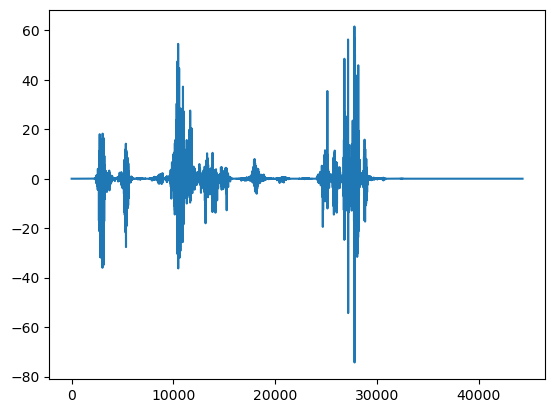

In [30]:
import matplotlib.pyplot as plt
plt.plot(1000*librosa.load(train_df['path'][1020], sr=CFG['SR'])[0]**3)

In [8]:
MODEL_NAME = "facebook/wav2vec2-base"
processor = Wav2Vec2FeatureExtractor.from_pretrained(MODEL_NAME)

class CustomDataSet(torch.utils.data.Dataset):
    def __init__(self, x, y, processor):
        self.x = x
        self.y = y
        self.processor = processor

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        input_values = self.processor(self.x[idx], sampling_rate=CFG['SR'], return_tensors="pt", padding=True).input_values
        if self.y is not None:
            return input_values.squeeze(), self.y[idx]
        else:
            return input_values.squeeze()

def collate_fn(batch):
    x, y = zip(*batch)
    x = pad_sequence([torch.tensor(xi) for xi in x], batch_first=True)
    y = pad_sequence([torch.tensor([yi]) for yi in y], batch_first=True)  # Convert scalar targets to 1D tensors
    return x, y

def create_data_loader(dataset, batch_size, shuffle, collate_fn, num_workers=0):
    return DataLoader(dataset,
                      batch_size=batch_size,
                      shuffle=shuffle,
                      collate_fn=collate_fn,
                      num_workers=num_workers
                      )

train_dataset = CustomDataSet(train_x, train_df['label'], processor)
test_dataset = CustomDataSet(test_x, y=None, processor=processor)

In [9]:
train_df['label'].value_counts()

# 0: angry
# 1: fear
# 2: sad
# 3: disgust
# 4: neutral
# 5: happy

0    867
2    859
5    853
3    852
1    848
4    722
Name: label, dtype: int64

In [10]:
# features = []
# path = train_df['path'][0]
        
# y, sr = librosa.load(path, sr=CFG['SR'])
# y = list(y)
# y.extend([0 for _ in range(80000-len(y))])
# features.append(y)

# len(y)

In [53]:
def get_feature_mel(df):
    features = []
    for i in tqdm(df['path']):
        # i = '/content/drive/MyDrive/hi/sound01'+i[1:]
        data, sr = librosa.load(i, sr=CFG['SR'])
        data = 1000*data**3
        n_fft = 2048
        win_length = 2048
        hop_length = 1024
        n_mels = 512-128
 
        D = np.abs(librosa.stft(data, n_fft=n_fft, win_length = win_length, hop_length=hop_length))
        mel = librosa.feature.melspectrogram(S=D, sr=sr, n_mels=n_mels, hop_length=hop_length, win_length=win_length)

        m_mel = mel.mean(axis=1)
        features.append(m_mel)
    return np.array(features)

train_mel = get_feature_mel(train_df)
# valid_mel = get_feature_mel(valid_df)
test_mel = get_feature_mel(test_df)

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/1881 [00:00<?, ?it/s]

In [9]:
import os
import random
import warnings
from sklearn.model_selection import train_test_split

import librosa
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

from transformers import AutoModelForAudioClassification, Wav2Vec2FeatureExtractor

warnings.filterwarnings(action='ignore')

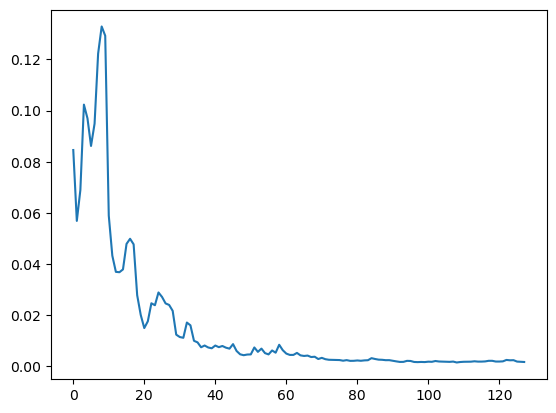

In [13]:
import matplotlib.pyplot as plt
plt.plot(train_mel[0])

In [48]:
def get_mfcc_feature(df):
    features = []
#     for path in tqdm(df['path']):
        
#         y, sr = librosa.load(path, sr=CFG['SR'])
#         y = list(y)
#         y.extend([0 for _ in range(80100-len(y))])
#         features.append(y)
    for path in tqdm(df['path']):
        # librosa패키지를 사용하여 wav 파일 load
        y, sr = librosa.load(path, sr=CFG['SR'])
        y = 1000*y**3
        # librosa패키지를 사용하여 mfcc 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])
        y_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e in mfcc:
            y_feature.append(np.mean(e))
        features.append(y_feature)
    return features
    # return pd.DataFrame(features,columns=['freq'])

vector = get_mfcc_feature(train_df)
test = get_mfcc_feature(test_df)

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/1881 [00:00<?, ?it/s]

In [49]:
np.array(vector).shape

(5001, 128)

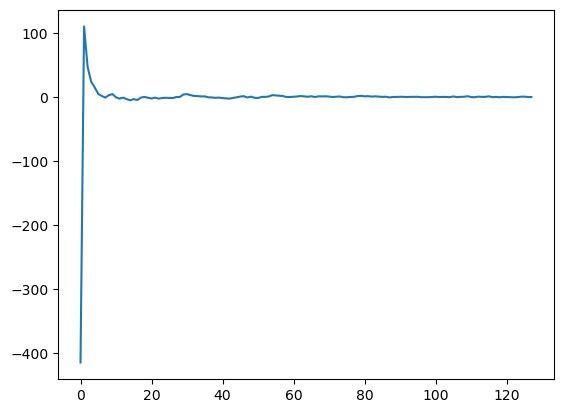

In [14]:
plt.plot(vector[0])

In [15]:
# train_df[train_df['label'] == 0].index

In [16]:
# from sklearn.decomposition import PCA
# pca 

# pd.DataFrameFrame(vector.iloc[])

In [17]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=600)
# pca.fit(vector)
# target = pd.DataFrame(pca.transform(vector))
# target.to_csv('./origin_600_pca.csv')

In [18]:
# import numpy as np
# max([len(i) for i in test])

In [19]:
# test = pd.DataFrame(pca.transform(test))
# test.to_csv('./test_600_pca.csv')

# print(sum(pca.explained_variance_ratio_))

In [56]:
target = pd.read_csv('./origin_600_pca.csv')
conc = pd.DataFrame([list(reversed(list(target.iloc[i,:]))) for i in range(len(target))])

In [57]:
conc = conc.rename(columns={i:f'pca_{i}' for i in range(600)})
target = target.rename(columns={f'{i}':f'pca_{i}' for i in range(600)}).drop('Unnamed: 0',axis=1)

In [58]:
target = pd.concat([target,conc])
target

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,...,pca_591,pca_592,pca_593,pca_594,pca_595,pca_596,pca_597,pca_598,pca_599,600
0,-0.021385,-0.012949,-0.015279,-0.011877,-0.025111,0.009895,-0.004037,-0.033308,0.008773,-0.014967,...,-0.021627,0.009855,0.002213,-0.011496,-0.020011,0.005312,-0.015379,-0.011613,-0.010847,NaN
1,0.000776,-0.021042,-0.005029,-0.016736,-0.010840,0.002814,-0.008290,-0.016119,-0.025994,-0.004446,...,-0.002577,0.012465,-0.003917,-0.002894,-0.017801,-0.007558,-0.012204,0.038600,-0.011025,NaN
2,0.052751,-0.054740,0.227633,0.128646,0.051232,0.086255,0.112322,-0.093411,-0.011321,-0.141729,...,-0.227377,0.047490,-0.014826,0.002115,0.098491,-0.055566,-0.131283,0.103348,0.003722,NaN
3,-0.002264,-0.053758,-0.065805,0.123830,-0.039335,-0.074199,0.080589,-0.034714,-0.094504,0.037295,...,0.246421,-0.030732,-0.010940,-0.126216,-0.159515,-0.083252,-0.060753,0.230066,-0.048657,NaN
4,0.012149,-0.100497,-0.033590,-0.113659,-0.128520,0.049028,-0.172694,-0.074595,0.006177,-0.125284,...,-0.055523,-0.011672,-0.177221,-0.020595,-0.111046,0.211206,0.203578,0.103752,-0.055185,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,-0.042877,-0.006561,-0.053777,-0.060315,-0.113231,0.025670,-0.042992,-0.027823,0.031745,0.033578,...,-0.062950,0.028914,0.007278,0.021489,0.004603,0.027164,-0.033432,-0.003941,0.004596,4996.0
4997,-0.110533,0.090996,0.126189,-0.044549,0.112800,-0.046879,-0.038362,-0.013591,-0.098096,0.214015,...,-1.044811,0.535062,-0.007586,-1.326804,-1.387200,-0.482458,-0.340060,-0.451134,-0.048009,4997.0
4998,-0.166486,0.070321,0.038598,-0.022319,-0.027345,0.090069,-0.003661,0.055641,-0.104162,-0.005171,...,0.005387,-0.079840,0.028089,0.177551,-0.074893,-0.156975,0.098310,-0.082456,0.011474,4998.0
4999,-0.052966,0.044866,0.057982,0.035652,0.082762,-0.037150,0.041298,-0.040216,-0.000206,-0.048188,...,0.010496,-0.027867,0.025754,-0.044363,-0.007708,-0.009071,-0.006900,-0.049939,-0.021732,4999.0


In [41]:
tp = pd.DataFrame(train_x)
tp.fillna(0,inplace=True)
tp

,0,1,2,3,4,5,6,7,8,9,...,77935,77936,77937,77938,77939,77940,77941,77942,77943,77944
0,0.000423,0.000553,0.000500,0.000566,0.000752,0.000760,0.000855,0.000923,0.000783,0.001147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.000100,-0.000145,-0.000186,-0.000238,-0.000275,-0.000248,-0.000214,-0.000177,-0.000121,-0.000070,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000460,0.000337,0.000303,0.000248,0.000204,0.000128,0.000128,0.000116,0.000075,0.000128,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000201,0.000201,0.000224,0.000241,0.000198,0.000195,0.000192,0.000160,0.000169,0.000092,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.000299,-0.000234,-0.000123,-0.000112,-0.000104,-0.000040,-0.000040,-0.000032,-0.000013,-0.000009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,0.000137,0.000112,0.000116,0.000135,0.000088,0.000112,0.000137,0.000163,0.000208,0.000189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.000651,0.000745,0.000604,0.000517,0.000686,0.000604,0.000482,0.000449,0.000267,0.000307,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,-0.000053,-0.000054,-0.000100,-0.000058,-0.000053,-0.000078,-0.000087,-0.000125,-0.000078,-0.000112,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4999,-0.000152,-0.000227,-0.000155,-0.000315,-0.000378,-0.000398,-0.000529,-0.000591,-0.000715,-0.000806,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
vector = pd.DataFrame(vector,columns=[f'mfcc_{i}' for i in range(128)])
train = pd.DataFrame(train_mel,columns=[f'mel_{i}' for i in range(512-128)])
train = train.rename(columns={f'{i}':f'mel_{i}' for i in range(128)})
train = pd.concat([train,vector],axis=1)
# train = pd.concat([train,tp],axis=1)
# del(tp)
train

,mel_0,mel_1,mel_2,mel_3,mel_4,mel_5,mel_6,mel_7,mel_8,mel_9,...,mfcc_118,mfcc_119,mfcc_120,mfcc_121,mfcc_122,mfcc_123,mfcc_124,mfcc_125,mfcc_126,mfcc_127
0,0.012796,0.017139,0.013971,0.011996,0.010280,0.010591,0.010656,0.009577,0.012072,0.011043,...,-0.060094,0.018266,-0.229225,-0.269986,-0.328177,-0.262188,-0.136601,-0.070472,-0.207806,-0.110601
1,0.018538,0.027314,0.030566,0.019357,0.018290,0.017026,0.016035,0.014943,0.014594,0.015915,...,0.247597,-0.042381,-0.238468,0.056018,-0.331646,-0.205095,0.070585,0.259338,-0.146463,-0.073543
2,0.914811,0.673310,0.495818,0.474627,0.397485,0.323601,0.368434,0.452021,0.424618,0.403028,...,-0.388673,-0.307896,0.075124,-0.229335,-0.279900,-0.205933,-0.085337,0.012471,-0.005942,-0.396504
3,0.934052,0.717046,0.531865,0.535355,0.562599,0.445513,0.290852,0.334588,0.363534,0.333056,...,0.318791,0.462187,0.019130,-0.073279,-0.178724,-0.249766,-0.479437,-0.163453,-0.003095,-0.186423
4,5.668504,4.186213,2.524818,2.119392,3.103342,3.642209,3.444093,3.635113,4.294995,4.536525,...,-0.165995,0.025326,-0.274354,-0.182354,0.279230,0.096126,-0.148470,-0.071157,-0.057014,-0.173333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,0.111645,0.093070,0.066315,0.051493,0.041220,0.047255,0.058171,0.069464,0.071075,0.084309,...,0.109059,0.138545,0.248872,-0.028358,-0.062060,-0.209703,-0.077951,0.011387,-0.069983,-0.212266
4997,188.221848,130.635345,87.615967,78.403038,68.234230,58.615822,44.839027,37.347416,29.456903,31.133081,...,-0.098748,-0.187932,0.291289,-0.049687,-0.140961,-0.032705,0.198065,0.154536,-0.160352,-0.067534
4998,0.201011,0.239809,0.296275,0.243934,0.187679,0.167938,0.203905,0.150936,0.112104,0.119830,...,0.150995,0.338122,0.237909,-0.166271,0.063727,-0.093311,0.052778,-0.023698,-0.429928,-0.333629
4999,0.030886,0.031448,0.032928,0.027360,0.019477,0.019061,0.025755,0.027535,0.021783,0.021801,...,0.052324,-0.051417,-0.153954,-0.746408,-0.587373,-0.364398,-0.215958,-0.213623,-0.093826,-0.284880


In [ ]:
train

In [55]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [56]:
def build_model():
    model = keras.Sequential([
        #layers.MaxPooling1D(),
        layers.Dense(1024, activation='relu', input_shape=[len(train.keys())]),
        # layers.Dense(1024, activation='relu'),
        # layers.MaxPooling1D(),
        # layers.Dense(512, activation='relu'),
        # layers.Dropout(0.1),
        layers.Dense(6,activation='softmax')
        ])

    optimizer = tf.keras.optimizers.Adam(0.005)

    model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                optimizer='adam',
                metrics=['accuracy'])
    return model
model = build_model()

In [57]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6150      
Total params: 531,462
Trainable params: 531,462
Non-trainable params: 0
_________________________________________________________________


In [59]:
import sklearn
skf = sklearn.model_selection.StratifiedKFold(n_splits=5)
# for i, (train_index, test_index) in enumerate(skf.split(train, train_df['label'])):
#     print(f"Fold {i}:")
#     print(f"  Train: index={train_index}")
#     print(f"  Test:  index={test_index}")

In [61]:
# class PrintDot(keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs):
#         if epoch % 100 == 0: print('')
#         print('.', end='')

# EPOCHS = 1000

# history = model.fit(
#   train, train_df['label'],
#   epochs=EPOCHS, validation_split = 0.1, verbose=0,
#   callbacks=[PrintDot()])



skf = sklearn.model_selection.StratifiedKFold(n_splits=5)
models = []
for i, (train_index, test_index) in enumerate(skf.split(train, train_df['label'])):
    model.fit(train.loc[train_index,:]
              , train_df.loc[train_index,'label']
              , epochs=100
              , validation_data=(train.loc[test_index,:],train_df.loc[test_index,'label'])) # validation_split=0.1,
    models.append(model)

Epoch 1/100
125/125 [==============================] - 0s 2ms/step - loss: 1.0105 - accuracy: 0.6233 - val_loss: 0.8814 - val_accuracy: 0.6643
Epoch 2/100
125/125 [==============================] - 0s 2ms/step - loss: 0.9295 - accuracy: 0.6515 - val_loss: 0.8769 - val_accuracy: 0.6733
Epoch 3/100
125/125 [==============================] - 0s 2ms/step - loss: 0.8903 - accuracy: 0.6492 - val_loss: 0.8606 - val_accuracy: 0.6613
Epoch 4/100
125/125 [==============================] - 0s 2ms/step - loss: 0.9144 - accuracy: 0.6622 - val_loss: 0.9010 - val_accuracy: 0.6593
Epoch 5/100
125/125 [==============================] - 0s 2ms/step - loss: 0.8579 - accuracy: 0.6710 - val_loss: 0.9594 - val_accuracy: 0.6434
Epoch 6/100
125/125 [==============================] - 0s 2ms/step - loss: 0.8685 - accuracy: 0.6870 - val_loss: 1.0358 - val_accuracy: 0.6264
Epoch 7/100
125/125 [==============================] - 0s 2ms/step - loss: 0.8414 - accuracy: 0.6855 - val_loss: 0.9958 - val_accuracy: 0.6364

Epoch 58/100
125/125 [==============================] - 0s 2ms/step - loss: 0.1902 - accuracy: 0.9433 - val_loss: 2.2415 - val_accuracy: 0.5604
Epoch 59/100
125/125 [==============================] - 0s 2ms/step - loss: 0.1737 - accuracy: 0.9435 - val_loss: 2.2537 - val_accuracy: 0.5504
Epoch 60/100
125/125 [==============================] - 0s 2ms/step - loss: 0.4036 - accuracy: 0.9305 - val_loss: 3.2180 - val_accuracy: 0.5435
Epoch 61/100
125/125 [==============================] - 0s 2ms/step - loss: 0.4875 - accuracy: 0.8907 - val_loss: 2.4102 - val_accuracy: 0.5684
Epoch 62/100
125/125 [==============================] - 0s 2ms/step - loss: 0.3083 - accuracy: 0.9000 - val_loss: 2.9833 - val_accuracy: 0.5245
Epoch 63/100
125/125 [==============================] - 0s 2ms/step - loss: 0.3389 - accuracy: 0.8800 - val_loss: 2.4984 - val_accuracy: 0.5395
Epoch 64/100
125/125 [==============================] - 0s 2ms/step - loss: 0.2042 - accuracy: 0.9323 - val_loss: 2.9293 - val_accuracy:

Epoch 15/100
126/126 [==============================] - 0s 2ms/step - loss: 0.4533 - accuracy: 0.8558 - val_loss: 0.4790 - val_accuracy: 0.8590
Epoch 16/100
126/126 [==============================] - 0s 2ms/step - loss: 0.2630 - accuracy: 0.9145 - val_loss: 0.4656 - val_accuracy: 0.8300
Epoch 17/100
126/126 [==============================] - 0s 2ms/step - loss: 0.3564 - accuracy: 0.8818 - val_loss: 0.6532 - val_accuracy: 0.8080
Epoch 18/100
126/126 [==============================] - 0s 2ms/step - loss: 0.2540 - accuracy: 0.9135 - val_loss: 0.4200 - val_accuracy: 0.8790
Epoch 19/100
126/126 [==============================] - 0s 2ms/step - loss: 0.2037 - accuracy: 0.9283 - val_loss: 0.4303 - val_accuracy: 0.8610
Epoch 20/100
126/126 [==============================] - 0s 2ms/step - loss: 0.1821 - accuracy: 0.9443 - val_loss: 0.4952 - val_accuracy: 0.8600
Epoch 21/100
126/126 [==============================] - 0s 2ms/step - loss: 0.1597 - accuracy: 0.9513 - val_loss: 0.3996 - val_accuracy:

Epoch 72/100
126/126 [==============================] - 0s 2ms/step - loss: 0.5856 - accuracy: 0.8385 - val_loss: 1.9439 - val_accuracy: 0.6960
Epoch 73/100
126/126 [==============================] - 0s 2ms/step - loss: 0.5456 - accuracy: 0.8790 - val_loss: 1.2243 - val_accuracy: 0.7290
Epoch 74/100
126/126 [==============================] - 0s 2ms/step - loss: 0.1887 - accuracy: 0.9483 - val_loss: 0.9292 - val_accuracy: 0.7820
Epoch 75/100
126/126 [==============================] - 0s 2ms/step - loss: 0.1576 - accuracy: 0.9663 - val_loss: 1.0620 - val_accuracy: 0.7620
Epoch 76/100
126/126 [==============================] - 0s 2ms/step - loss: 0.1347 - accuracy: 0.9733 - val_loss: 0.9004 - val_accuracy: 0.7830
Epoch 77/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0554 - accuracy: 0.9850 - val_loss: 0.9133 - val_accuracy: 0.7860
Epoch 78/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0451 - accuracy: 0.9845 - val_loss: 0.8836 - val_accuracy:

Epoch 29/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0712 - accuracy: 0.9755 - val_loss: 0.1680 - val_accuracy: 0.9470
Epoch 30/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0763 - accuracy: 0.9748 - val_loss: 0.2280 - val_accuracy: 0.9360
Epoch 31/100
126/126 [==============================] - 0s 2ms/step - loss: 0.1119 - accuracy: 0.9593 - val_loss: 0.3883 - val_accuracy: 0.8900
Epoch 32/100
126/126 [==============================] - 0s 2ms/step - loss: 0.1998 - accuracy: 0.9303 - val_loss: 0.4072 - val_accuracy: 0.8720
Epoch 33/100
126/126 [==============================] - 0s 2ms/step - loss: 0.2397 - accuracy: 0.9220 - val_loss: 0.4873 - val_accuracy: 0.8650
Epoch 34/100
126/126 [==============================] - 0s 2ms/step - loss: 0.2300 - accuracy: 0.9440 - val_loss: 2.2399 - val_accuracy: 0.9000
Epoch 35/100
126/126 [==============================] - 0s 2ms/step - loss: 0.3010 - accuracy: 0.9573 - val_loss: 0.2731 - val_accuracy:

Epoch 86/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0225 - accuracy: 0.9913 - val_loss: 0.4786 - val_accuracy: 0.8920
Epoch 87/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0287 - accuracy: 0.9915 - val_loss: 0.5295 - val_accuracy: 0.8880
Epoch 88/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0290 - accuracy: 0.9903 - val_loss: 0.4273 - val_accuracy: 0.8810
Epoch 89/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0753 - accuracy: 0.9800 - val_loss: 0.6928 - val_accuracy: 0.8800
Epoch 90/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0677 - accuracy: 0.9830 - val_loss: 0.8053 - val_accuracy: 0.8800
Epoch 91/100
126/126 [==============================] - 0s 2ms/step - loss: 0.2264 - accuracy: 0.9613 - val_loss: 1.1959 - val_accuracy: 0.8230
Epoch 92/100
126/126 [==============================] - 0s 2ms/step - loss: 0.8173 - accuracy: 0.8275 - val_loss: 1.3652 - val_accuracy:

Epoch 43/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0204 - accuracy: 0.9933 - val_loss: 0.1681 - val_accuracy: 0.9700
Epoch 44/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0269 - accuracy: 0.9893 - val_loss: 0.3255 - val_accuracy: 0.9530
Epoch 45/100
126/126 [==============================] - 0s 2ms/step - loss: 0.8291 - accuracy: 0.8393 - val_loss: 0.9191 - val_accuracy: 0.7610
Epoch 46/100
126/126 [==============================] - 0s 2ms/step - loss: 0.6494 - accuracy: 0.8428 - val_loss: 0.7943 - val_accuracy: 0.8500
Epoch 47/100
126/126 [==============================] - 0s 2ms/step - loss: 0.2988 - accuracy: 0.9153 - val_loss: 0.4258 - val_accuracy: 0.8890
Epoch 48/100
126/126 [==============================] - 0s 2ms/step - loss: 0.4897 - accuracy: 0.8955 - val_loss: 0.6684 - val_accuracy: 0.8450
Epoch 49/100
126/126 [==============================] - 0s 2ms/step - loss: 0.2147 - accuracy: 0.9383 - val_loss: 0.3799 - val_accuracy:

Epoch 100/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0119 - accuracy: 0.9958 - val_loss: 0.3785 - val_accuracy: 0.9230
Epoch 1/100
126/126 [==============================] - 0s 2ms/step - loss: 0.8068 - accuracy: 0.8560 - val_loss: 0.6832 - val_accuracy: 0.8230
Epoch 2/100
126/126 [==============================] - 0s 2ms/step - loss: 0.5486 - accuracy: 0.8708 - val_loss: 0.3506 - val_accuracy: 0.8900
Epoch 3/100
126/126 [==============================] - 0s 2ms/step - loss: 0.3293 - accuracy: 0.9253 - val_loss: 0.2785 - val_accuracy: 0.9250
Epoch 4/100
126/126 [==============================] - 0s 2ms/step - loss: 0.1824 - accuracy: 0.9585 - val_loss: 0.1224 - val_accuracy: 0.9560
Epoch 5/100
126/126 [==============================] - 0s 2ms/step - loss: 0.1332 - accuracy: 0.9585 - val_loss: 0.0940 - val_accuracy: 0.9690
Epoch 6/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0539 - accuracy: 0.9830 - val_loss: 0.0443 - val_accuracy: 0.98

Epoch 57/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0199 - accuracy: 0.9943 - val_loss: 0.1027 - val_accuracy: 0.9710
Epoch 58/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0134 - accuracy: 0.9960 - val_loss: 0.1072 - val_accuracy: 0.9700
Epoch 59/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0126 - accuracy: 0.9965 - val_loss: 0.1055 - val_accuracy: 0.9720
Epoch 60/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0122 - accuracy: 0.9965 - val_loss: 0.1070 - val_accuracy: 0.9720
Epoch 61/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0115 - accuracy: 0.9968 - val_loss: 0.1071 - val_accuracy: 0.9710
Epoch 62/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0115 - accuracy: 0.9965 - val_loss: 0.1047 - val_accuracy: 0.9720
Epoch 63/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0110 - accuracy: 0.9968 - val_loss: 0.1036 - val_accuracy:

In [84]:
# from pycaret import classification
# classification.setup(data=train,target='label')

ImportError: cannot import name 'classification' from 'pycaret' (/Users/junho/miniforge3/envs/ml_dl/lib/python3.8/site-packages/pycaret/__init__.py)

In [69]:
vector = get_mfcc_feature(test_df)

  0%|          | 0/1881 [00:00<?, ?it/s]

In [70]:
test = pd.DataFrame(test_mel,columns=[f'mel_{i}' for i in range(384)])
vector = pd.DataFrame(vector,columns=[f'mfcc_{i}' for i in range(128)])
test = pd.concat([test,vector],axis=1)

In [71]:
models

In [72]:
preds = [i.predict(test) for i in models]
preds = [np.argmax(i) for i in np.array(preds).mean(axis=0)]
len(preds)

1881

In [76]:
submission = pd.read_csv('./sample_submission.csv')
submission['label'] = [np.argmax(i) for i in models[4].predict(test)]
submission.to_csv('./baseline_submission.csv', index=False)